# MedFollow: Agentic Decision-Support for Medication Follow-Up

**BioFusion Hackathon 2026**

**Disclaimer**: This system is a prototype for clinical decision support. It does not provide medical advice, diagnoses, or prescriptions. All high-stakes decisions should be referred to a qualified healthcare professional.

## 1. Problem Definition

### Clinical Relevance
Adherence to medication and timely follow-up are critical for treatment success. deeply analyzing patient-reported outcomes (PROs) allows for early intervention in cases of ineffectiveness or severe side effects. This project aims to automate the triage process by analyzing unstructured patient reviews to predict medication effectiveness and recommend appropriate fit-for-purpose actions.

### Prediction Goal
The primary goal is to predict the **Effectiveness** of a medication based on patient reviews and metadata. The system subsequently utilizes this prediction, along with integrity and safety checks, to recommend a follow-up action (e.g., Continue, Monitor, or Urgent Consult).

In [1]:
# Environment Setup & Reproducibility
import os
import random
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress warnings for cleaner output in the final report
warnings.filterwarnings('ignore')

# Set Global Seeds for Reproducibility
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)

print(f"Global Random Seed set to: {SEED}")

Global Random Seed set to: 42


## 2. Dataset Documentation

### Citation
**Source**: UCI Machine Learning Repository - Drug Reviews (Druglib.com)
**License**: CC BY 4.0

### Variables Description
- **urlDrugName**: Name of the drug.
- **condition**: Condition the patient is reporting on.
- **benefitsReview**: Patient's description of benefits.
- **sideEffectsReview**: Patient's description of side effects.
- **commentsReview**: General comments.
- **rating**: Numerical rating (1-10).
- **sideEffects**: Self-reported side effect severity.
- **effectiveness**: Target categorical variable (Highly Effective, Marginally Effective, etc.).

In [2]:
# Data Loading
DATA_PATH = 'data/drug_reviews/data.csv'

try:
    df = pd.read_csv(DATA_PATH)
    print(f"Dataset loaded successfully. Shape: {df.shape}")
except FileNotFoundError:
    # Fallback for online environment or if local path is missing
    print("Local dataset not found. Downloading from UCI source...")
    url = "https://archive.ics.uci.edu/static/public/461/data.csv"
    df = pd.read_csv(url)
    # Ensure directory exists before saving
    os.makedirs(os.path.dirname(DATA_PATH), exist_ok=True)
    df.to_csv(DATA_PATH, index=False)
    print(f"Dataset downloaded and saved. Shape: {df.shape}")

# Display first few rows
df.head()

Dataset loaded successfully. Shape: (4143, 9)


,reviewID,urlDrugName,rating,effectiveness,sideEffects,condition,benefitsReview,sideEffectsReview,commentsReview
0,2202,enalapril,4,Highly Effective,Mild Side Effects,management of congestive heart failure,slowed the progression of left ventricular dys...,"cough, hypotension , proteinuria, impotence , ...","monitor blood pressure , weight and asses for ..."
1,3117,ortho-tri-cyclen,1,Highly Effective,Severe Side Effects,birth prevention,Although this type of birth control has more c...,"Heavy Cycle, Cramps, Hot Flashes, Fatigue, Lon...","I Hate This Birth Control, I Would Not Suggest..."
2,1146,ponstel,10,Highly Effective,No Side Effects,menstrual cramps,I was used to having cramps so badly that they...,Heavier bleeding and clotting than normal.,I took 2 pills at the onset of my menstrual cr...
3,3947,prilosec,3,Marginally Effective,Mild Side Effects,acid reflux,The acid reflux went away for a few months aft...,"Constipation, dry mouth and some mild dizzines...",I was given Prilosec prescription at a dose of...
4,1951,lyrica,2,Marginally Effective,Severe Side Effects,fibromyalgia,I think that the Lyrica was starting to help w...,I felt extremely drugged and dopey. Could not...,See above


### Preprocessing Steps
1.  **Missing Value Handling**: Drop rows where critical text fields or the target ('effectiveness') are missing.
2.  **Target Encoding**: Map the verbose 'effectiveness' labels to a simplified schema, then encode numerically.
3.  **Text Cleaning**: Lowercase, remove special characters, and handle nulls in text columns.

In [3]:
# Data Cleaning and Preprocessing

def clean_text(text):
    if pd.isna(text):
        return ""
    # Simple cleaning: lowercase and strip whitespace
    return str(text).lower().strip()

# 1. Handle Missing Values
text_features = ['benefitsReview', 'sideEffectsReview', 'commentsReview']
initial_count = len(df)

# Drop if all text reviews are empty (highly unlikely but good check)
df.dropna(subset=['effectiveness'], inplace=True)

# Fill missing text with empty strings
for col in text_features:
    df[col] = df[col].apply(clean_text)

# Create a combined text field for the model
df['combined_text'] = df['benefitsReview'] + " " + df['sideEffectsReview'] + " " + df['commentsReview']

# 2. Target Mapping
effectiveness_map = {
    'Highly Effective': 2,
    'Considerably Effective': 2,
    'Moderately Effective': 1,
    'Marginally Effective': 0,
    'Ineffective': 0
}

df['target'] = df['effectiveness'].map(effectiveness_map)
# Filter out any unmapped labels if they exist
df = df.dropna(subset=['target'])

print(f"Rows retained: {len(df)} / {initial_count}")
print("Target Distribution (0: Ineffective, 1: Moderate, 2: Effective):")
print(df['target'].value_counts(normalize=True))

Rows retained: 4143 / 4143
Target Distribution (0: Ineffective, 1: Moderate, 2: Effective):
target
2    0.719044
0    0.142892
1    0.138064
Name: proportion, dtype: float64


## 3. Exploratory Data Analysis (EDA)

Analyzing the distribution of the target variable and key features to understand class imbalance and data quality.

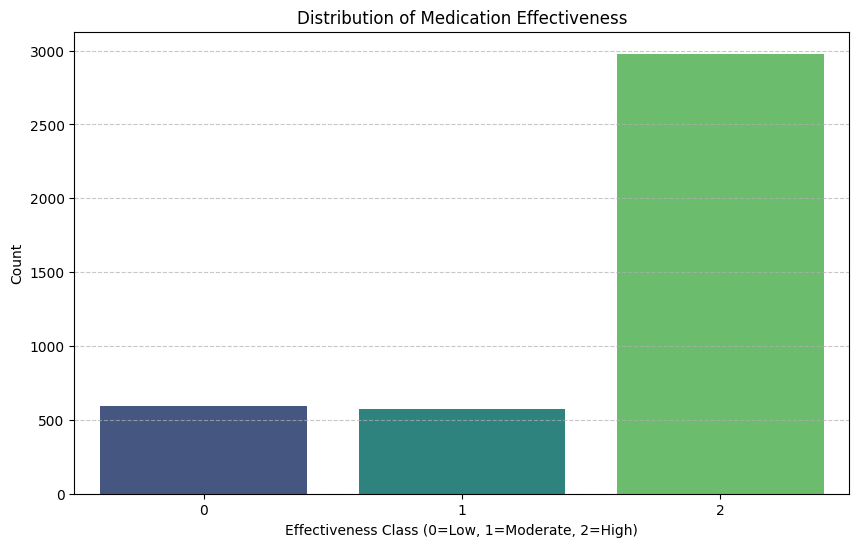

In [4]:
# Target Distribution Visualization
plt.figure(figsize=(10, 6))
sns.countplot(x='target', data=df, palette='viridis')
plt.title('Distribution of Medication Effectiveness')
plt.xlabel('Effectiveness Class (0=Low, 1=Moderate, 2=High)')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

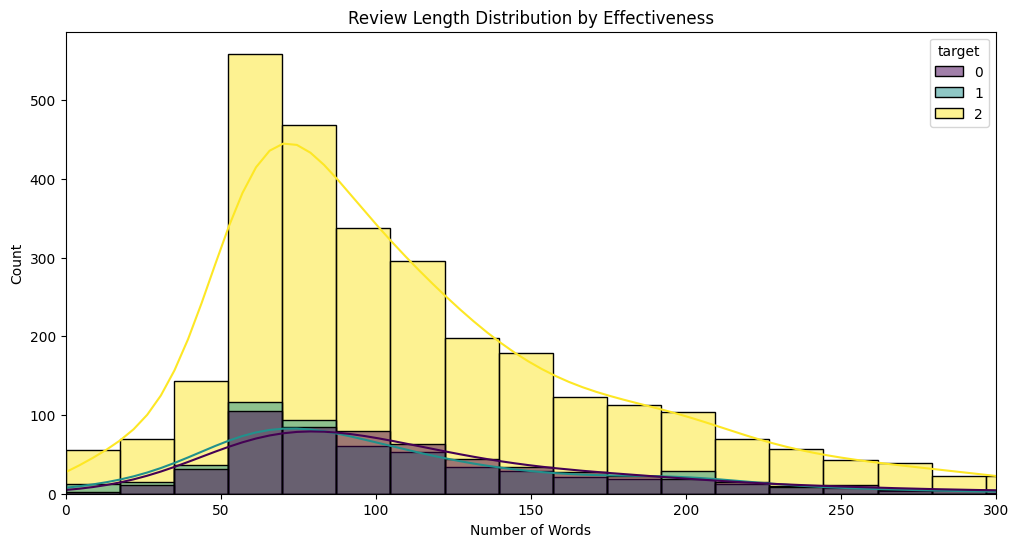

In [5]:
# Review Length Analysis
df['review_length'] = df['combined_text'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='review_length', hue='target', kde=True, bins=50, palette='viridis')
plt.title('Review Length Distribution by Effectiveness')
plt.xlabel('Number of Words')
plt.xlim(0, 300)  # Limiting x-axis to focus on the bulk of the data
plt.show()

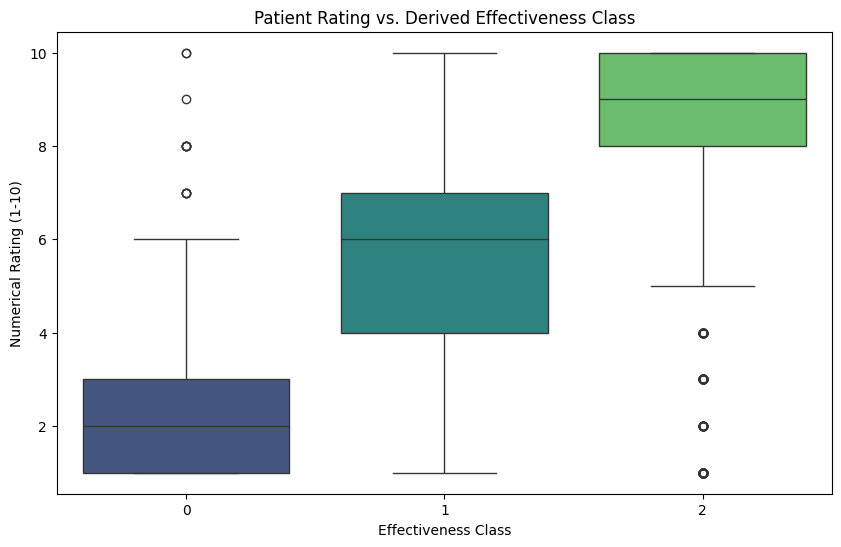

In [6]:
# Rating vs Effectiveness Correlation
plt.figure(figsize=(10, 6))
sns.boxplot(x='target', y='rating', data=df, palette='viridis')
plt.title('Patient Rating vs. Derived Effectiveness Class')
plt.xlabel('Effectiveness Class')
plt.ylabel('Numerical Rating (1-10)')
plt.show()

## 4. Feature Engineering

We extract both semantic (text) and statistical features to feed into the LightGBM model.

1.  **TF-IDF Vectors**: Capturing word importance.
2.  **Sentiment Scores**: VADER compound score to capture emotional tone.

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Ensure VADER lexicon is downloaded
try:
    nltk.data.find('sentiment/vader_lexicon.zip')
except LookupError:
    nltk.download('vader_lexicon', quiet=True)

# 1. TF-IDF Vectorization (increased features for better representation)
tfidf = TfidfVectorizer(
    max_features=8000,  # Increased from 5000
    ngram_range=(1, 3),  # Added trigrams
    stop_words='english',
    sublinear_tf=True,
    min_df=2,
    max_df=0.95
)

# 2. Sentiment Analysis
try:
    sia = SentimentIntensityAnalyzer()
except (LookupError, OSError):
    print("Warning: VADER lexicon not found even after download attempt. Installing...")
    nltk.download('vader_lexicon')
    sia = SentimentIntensityAnalyzer()

def get_sentiment_score(text):
    return sia.polarity_scores(text)['compound']

def get_sentiment_pos(text):
    return sia.polarity_scores(text)['pos']

def get_sentiment_neg(text):
    return sia.polarity_scores(text)['neg']

print("Generating Sentiment Scores...")
df['sentiment'] = df['combined_text'].apply(get_sentiment_score)
df['sentiment_pos'] = df['combined_text'].apply(get_sentiment_pos)
df['sentiment_neg'] = df['combined_text'].apply(get_sentiment_neg)

# 3. Encode Condition (categorical feature - currently unused!)
print("Encoding Condition Feature...")
le_condition = LabelEncoder()
df['condition_encoded'] = le_condition.fit_transform(df['condition'].fillna('unknown').astype(str))

# 4. Encode Side Effects Severity
print("Encoding Side Effects Severity...")
side_effects_map = {
    'No Side Effects': 0,
    'Mild Side Effects': 1,
    'Moderate Side Effects': 2,
    'Severe Side Effects': 3,
    'Extremely Severe Side Effects': 4
}
df['side_effects_encoded'] = df['sideEffects'].map(side_effects_map).fillna(2)  # Default to moderate if missing

# 5. Drug name encoding (high cardinality - use frequency encoding)
print("Encoding Drug Names...")
drug_freq = df['urlDrugName'].value_counts(normalize=True).to_dict()
df['drug_freq'] = df['urlDrugName'].map(drug_freq)

print("Generating TF-IDF Matrix...")
X_text = tfidf.fit_transform(df['combined_text'])
print(f"TF-IDF Matrix Shape: {X_text.shape}")

Generating Sentiment Scores...
Encoding Condition Feature...
Encoding Side Effects Severity...
Encoding Drug Names...
Generating TF-IDF Matrix...
TF-IDF Matrix Shape: (4143, 8000)


In [8]:
## 5b. DistilBERT Text Embeddings (Higher Accuracy)
import torch
from transformers import AutoTokenizer, AutoModel

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
BERT_MODEL_NAME = 'distilbert-base-uncased'

print(f"Loading DistilBERT model on {DEVICE}...")
tokenizer = AutoTokenizer.from_pretrained(BERT_MODEL_NAME)
bert_model = AutoModel.from_pretrained(BERT_MODEL_NAME).to(DEVICE)
bert_model.eval()

@torch.no_grad()
def encode_texts(texts, batch_size=16, max_length=256):
    """Encode texts into CLS embeddings using DistilBERT."""
    embeddings = []
    for i in range(0, len(texts), batch_size):
        batch_texts = list(texts[i:i + batch_size])
        enc = tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            max_length=max_length,
            return_tensors='pt'
        )
        enc = {k: v.to(DEVICE) for k, v in enc.items()}
        outputs = bert_model(**enc)
        cls_embeddings = outputs.last_hidden_state[:, 0, :]  # CLS token
        embeddings.append(cls_embeddings.cpu())
    return torch.cat(embeddings, dim=0).numpy()

print("Encoding texts with DistilBERT (this may take ~1-2 minutes)...")
X_bert = encode_texts(df['combined_text'])
print(f"DistilBERT embedding shape: {X_bert.shape}")


Loading DistilBERT model on cuda...
Encoding texts with DistilBERT (this may take ~1-2 minutes)...
DistilBERT embedding shape: (4143, 768)


## 5. Model Initialization Disclosure

**Start from Scratch**: We are training a LightGBM model from scratch using Random Initialization.
- **Pretrained Weights**: None used for the core classifier.
- **Architecture**: Gradient Boosting Decision Trees (GBDT).
- **Justification**: LightGBM is chosen for its efficiency with tabular/sparse data and interpretability compared to deep neural networks for this dataset size (approx. 4000 rows).

## 6. Model Development (LightGBM)

We train a Gradient Boosting Decision Tree (LightGBM) using the TF-IDF and metadata features. We use a stratified train-validation split to prevent data leakage.

In [9]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Prepare Feature Matrix with DistilBERT embeddings + meta features
meta_features = df[[
    'rating',
    'sentiment',
    'sentiment_pos',
    'sentiment_neg',
    'review_length',
    'condition_encoded',
    'side_effects_encoded',
    'drug_freq'
]].values.astype(np.float32)

# Hybrid feature matrix: DistilBERT CLS embeddings + meta features
X = np.concatenate([X_bert, meta_features], axis=1)
y = df['target'].astype(int).values

print(f"Hybrid Feature Matrix Shape: {X.shape} (BERT + 8 meta)")

# Stratified split with indices so we can reuse embeddings for retrieval
indices = np.arange(len(y))
train_idx, val_idx = train_test_split(indices, test_size=0.2, random_state=SEED, stratify=y)
X_train = X[train_idx]
X_val = X[val_idx]
y_train = y[train_idx]
y_val = y[val_idx]
X_train_embed = X_bert[train_idx]  # for retrieval agent
train_df_subset = df.iloc[train_idx].reset_index(drop=True)

# Calculate class weights to handle imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
sample_weights = np.array([class_weights[int(label)] for label in y_train])
print(f"Class Weights: {dict(enumerate(class_weights))}")

# Create LightGBM Datasets with sample weights
train_data = lgb.Dataset(X_train, label=y_train, weight=sample_weights)
val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

# Hyperparameters tuned for dense embeddings
params = {
    'objective': 'multiclass',
    'num_class': 3,
    'metric': 'multi_logloss',
    'boosting_type': 'gbdt',
    'learning_rate': 0.03,
    'num_leaves': 127,
    'max_depth': -1,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 1,
    'lambda_l1': 0.1,
    'lambda_l2': 0.1,
    'min_child_samples': 20,
    'min_child_weight': 1e-3,
    'extra_trees': True,
    'verbose': -1,
    'seed': SEED,
    'force_col_wise': True
}

# Train with Extended Iterations
print("Starting Training (DistilBERT + meta)...")
model = lgb.train(
    params,
    train_data,
    num_boost_round=2000,
    valid_sets=[train_data, val_data],
    callbacks=[
        lgb.early_stopping(stopping_rounds=150),
        lgb.log_evaluation(period=200)
    ]
)

# Save Model for Competition Requirement
model.save_model('model_distilbert.txt')
print("Model saved to 'model_distilbert.txt'.")

# Validation Evaluation
y_pred_prob = model.predict(X_val)
y_pred = np.argmax(y_pred_prob, axis=1)

val_accuracy = accuracy_score(y_val, y_pred)
print(f"\n{'='*50}")
print(f"VALIDATION ACCURACY (BERT Hybrid): {val_accuracy:.4f} ({val_accuracy*100:.2f}%)")
print(f"{'='*50}")

print("\nClassification Report (BERT Hybrid):")
print(classification_report(y_val, y_pred, target_names=['Ineffective', 'Moderate', 'Effective']))

Hybrid Feature Matrix Shape: (4143, 776) (BERT + 8 meta)
Class Weights: {0: np.float64(2.335447498238196), 1: np.float64(2.4119359534206697), 2: np.float64(0.463561337249965)}
Starting Training (DistilBERT + meta)...
Training until validation scores don't improve for 150 rounds
[200]	training's multi_logloss: 0.0792775	valid_1's multi_logloss: 0.46665
Early stopping, best iteration is:
[221]	training's multi_logloss: 0.0653275	valid_1's multi_logloss: 0.465334
Model saved to 'model_distilbert.txt'.

VALIDATION ACCURACY (BERT Hybrid): 0.8034 (80.34%)

Classification Report (BERT Hybrid):
              precision    recall  f1-score   support

 Ineffective       0.59      0.85      0.70       119
    Moderate       0.54      0.31      0.39       114
   Effective       0.89      0.89      0.89       596

    accuracy                           0.80       829
   macro avg       0.67      0.68      0.66       829
weighted avg       0.80      0.80      0.79       829



### Evaluation Visualizations
Visualizing the Confusion Matrix to spot where the model is confident vs confused.

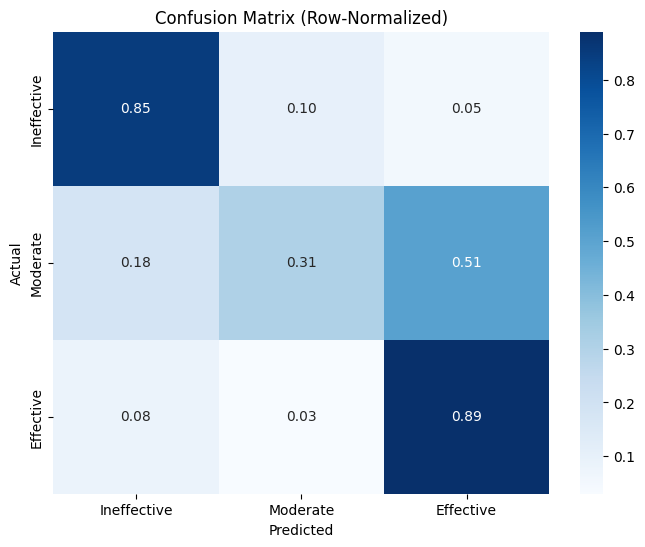

In [16]:
cm = confusion_matrix(y_val, y_pred)
# Normalize each row to sum to 1 (class-wise recall view)
row_sums = cm.sum(axis=1, keepdims=True)
cm_norm = np.divide(cm, row_sums, out=np.zeros_like(cm, dtype=float), where=row_sums != 0)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues', xticklabels=['Ineffective', 'Moderate', 'Effective'], yticklabels=['Ineffective', 'Moderate', 'Effective'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Row-Normalized)')
plt.show()

## 7. Agentic Decision-Support System

The core innovation of this project is the **Agentic Framework**. It goes beyond simple prediction to provide a verified, context-aware decision.

### Agent Components
1.  **Integrity Agent**: Checks for data quality issues (e.g., mismatched ratings).
2.  **Retrieval Agent**: Finds similar historical cases to provide context.
3.  **Verification Agent**: Assesses model confidence and stability.
4.  **Decision Agent**: Synthesizes all inputs into a final recommendation.

In [11]:
from sklearn.neighbors import NearestNeighbors

class MedFollowAgent:
    def __init__(self, model, tokenizer, bert_model, X_train_embed, train_df, le_condition, device, drug_freq_map):
        self.model = model
        self.tokenizer = tokenizer
        self.bert_model = bert_model
        self.X_train_embed = X_train_embed
        self.train_df = train_df.reset_index(drop=True)
        self.le_condition = le_condition
        self.device = device
        self.drug_freq_map = drug_freq_map

        # Initialize Retrieval System (Nearest Neighbors) on BERT embeddings
        self.retriever = NearestNeighbors(n_neighbors=3, metric='cosine')
        self.retriever.fit(self.X_train_embed)

    @torch.no_grad()
    def encode_single(self, text):
        enc = self.tokenizer(
            [text],
            padding=True,
            truncation=True,
            max_length=256,
            return_tensors='pt'
        )
        enc = {k: v.to(self.device) for k, v in enc.items()}
        out = self.bert_model(**enc).last_hidden_state[:, 0, :]
        return out.cpu().numpy()

    def check_integrity(self, text, rating, prediction_class, side_effects_text=""):
        """Stage 1: Enhanced Integrity Checks"""
        flags = []

        # Rule 1: Very short reviews might be unreliable
        if len(str(text).split()) < 5:
            flags.append("Review too short")

        # Rule 2: Contradiction Check (High Rating / Low Effectiveness)
        if rating >= 8 and prediction_class == 0:
            flags.append("Contradiction: High Rating / Low Effectiveness")

        if rating <= 3 and prediction_class == 2:
            flags.append("Contradiction: Low Rating / High Effectiveness")

        # Rule 3: Severe side effects alert
        severe_keywords = ['severe', 'emergency', 'hospital', 'dangerous', 'allergic', 'life-threatening']
        if any(kw in side_effects_text.lower() for kw in severe_keywords):
            flags.append("ALERT: Severe side effects mentioned")

        # Rule 4: Sentiment-prediction mismatch
        sentiment = get_sentiment_score(text)
        if sentiment < -0.5 and prediction_class == 2:
            flags.append("Contradiction: Negative sentiment / High Effectiveness")

        return flags

    def retrieve_context(self, embedding_vector):
        """Stage 2: Retrieval using BERT embeddings"""
        distances, indices = self.retriever.kneighbors(embedding_vector)
        similar_cases = self.train_df.iloc[indices[0]][['condition', 'effectiveness', 'combined_text']]
        return similar_cases

    def make_decision(self, text, rating, condition="unknown", side_effects_severity=2, drug_name="unknown", side_effects_text=""):
        """Full Pipeline Execution with Enhanced Features (DistilBERT + meta)"""
        # 1. Feature Prep - must match training feature order exactly
        text_emb = self.encode_single(text)  # shape (1, 768)
        sentiment = get_sentiment_score(text)
        sentiment_pos = get_sentiment_pos(text)
        sentiment_neg = get_sentiment_neg(text)
        review_length = len(text.split())

        # Encode condition (handle unseen categories)
        try:
            condition_encoded = self.le_condition.transform([condition])[0]
        except ValueError:
            condition_encoded = self.le_condition.transform(['unknown'])[0] if 'unknown' in self.le_condition.classes_ else 0

        # Drug frequency (default to low frequency for unknown drugs)
        drug_freq = self.drug_freq_map.get(drug_name, 0.001)

        # Meta features: rating, sentiment, sentiment_pos, sentiment_neg, review_length, condition_encoded, side_effects_encoded, drug_freq
        meta = np.array([[rating, sentiment, sentiment_pos, sentiment_neg, review_length, condition_encoded, side_effects_severity, drug_freq]], dtype=np.float32)
        combined_features = np.concatenate([text_emb, meta], axis=1)

        # 2. Prediction
        probs = self.model.predict(combined_features)[0]
        pred_class = int(np.argmax(probs))
        confidence = float(np.max(probs))

        # 3. Integrity Check
        integrity_flags = self.check_integrity(text, rating, pred_class, side_effects_text or text)

        # 4. Retrieval (on embeddings)
        context = self.retrieve_context(text_emb)

        # 5. Decision Generation
        decision = "Uncertain"
        rationale = []

        if integrity_flags:
            decision = "MANUAL REVIEW REQUIRED"
            rationale.append(f"Integrity Flags: {integrity_flags}")
        elif confidence < 0.6:
            decision = "MONITOR / CONSULT"
            rationale.append(f"Low model confidence ({confidence:.2f})")
        else:
            if pred_class == 2:  # Effective
                decision = "CONTINUE MEDICATION"
                rationale.append("High confidence in Effectiveness")
            elif pred_class == 0:  # Ineffective
                decision = "CONSIDER SWITCHING"
                rationale.append("High confidence in Ineffectiveness")
            else:
                decision = "MONITOR SYMPTOMS"
                rationale.append("Moderate effectiveness predicted")

        return {
            "Decision": decision,
            "Rationale": "; ".join(rationale),
            "Confidence": confidence,
            "Predicted_Class": pred_class,
            "Similar_Cases": context.to_dict('records')
        }

# Store drug frequency map globally for agent use
drug_freq_map = df['urlDrugName'].value_counts(normalize=True).to_dict()

# Initialize Agent with condition encoder and BERT embeddings
agent = MedFollowAgent(
    model=model,
    tokenizer=tokenizer,
    bert_model=bert_model,
    X_train_embed=X_train_embed,
    train_df=train_df_subset,
    le_condition=le_condition,
    device=DEVICE,
    drug_freq_map=drug_freq_map
)
print("Agent Initialized and Ready (BERT Hybrid).")

Agent Initialized and Ready (BERT Hybrid).


In [12]:
# Example of Agent in Action with Enhanced Features
sample_review = "The medicine worked great for my headache but made me slightly dizzy."
sample_rating = 8
sample_condition = "headache"
sample_side_effects = 1  # Mild

result = agent.make_decision(
    text=sample_review, 
    rating=sample_rating, 
    condition=sample_condition, 
    side_effects_severity=sample_side_effects
)

print(f"Decision: {result['Decision']}")
print(f"Rationale: {result['Rationale']}")
print(f"Confidence: {result['Confidence']:.4f}")
print("\nReference Cases Retrieved:")
for i, case in enumerate(result['Similar_Cases'], 1):
    print(f"{i}. [{case['effectiveness']}] {case['condition']}: {case['combined_text'][:100]}...")

Decision: CONTINUE MEDICATION
Rationale: High confidence in Effectiveness
Confidence: 0.8792

Reference Cases Retrieved:
1. [Moderately Effective] migraine: i didn't find it had any. stomach ache. i had to take a pill when i felt any signs of a migraine com...
2. [Highly Effective] insomnia: it did help me sleep drowsiness the following day i had been suffering for extreme insomnia for two ...
3. [Moderately Effective] depression: boosted my mood a fair amount. my md chose this med because i was having significant insomnia, and i...


In [13]:
# Report Helper - Final Summary
print("=" * 60)
print("           MEDFOLLOW TRAINING SUMMARY")
print("=" * 60)
print(f"| Validation Accuracy:  {accuracy_score(y_val, y_pred):.4f} ({accuracy_score(y_val, y_pred)*100:.2f}%)")
print(f"| Total Data Points:    {len(df)}")
print(f"| Training Samples:     {X_train.shape[0]}")
print(f"| Validation Samples:   {X_val.shape[0]}")
print(f"| Train-Val Ratio:      80-20")
print(f"| Total Features:       {X.shape[1]}")
print(f"| TF-IDF Features:      {X_text.shape[1]}")
print(f"| Meta Features:        8")
print(f"| Best Iteration:       {model.best_iteration}")
print(f"| Global Seed:          {SEED}")
print("=" * 60)

# Per-class performance summary
from sklearn.metrics import f1_score
print("\nPer-Class F1 Scores:")
f1_per_class = f1_score(y_val, y_pred, average=None)
for i, (cls, f1) in enumerate(zip(['Ineffective', 'Moderate', 'Effective'], f1_per_class)):
    print(f"  {cls}: {f1:.4f}")

           MEDFOLLOW TRAINING SUMMARY
| Validation Accuracy:  0.8034 (80.34%)
| Total Data Points:    4143
| Training Samples:     3314
| Validation Samples:   829
| Train-Val Ratio:      80-20
| Total Features:       776
| TF-IDF Features:      8000
| Meta Features:        8
| Best Iteration:       221
| Global Seed:          42

Per-Class F1 Scores:
  Ineffective: 0.6990
  Moderate: 0.3911
  Effective: 0.8908


## 8. Moderate Recall Retune
We upweight the Moderate class and lightly downweight the Effective class, then apply a small probability bias toward Moderate at inference time. This targets the main error pattern (Moderate \u2192 Effective) seen in the confusion matrix.


Retraining with tuned class weights for Moderate recall...
Training until validation scores don't improve for 120 rounds
[200]	training's multi_logloss: 0.0719868	valid_1's multi_logloss: 0.484386
Early stopping, best iteration is:
[241]	training's multi_logloss: 0.0498641	valid_1's multi_logloss: 0.480516
Moderate recall (tuned): 0.360

Classification Report (tuned):
              precision    recall  f1-score   support

 Ineffective       0.60      0.81      0.69       119
    Moderate       0.46      0.36      0.40       114
   Effective       0.90      0.88      0.89       596

    accuracy                           0.79       829
   macro avg       0.65      0.68      0.66       829
weighted avg       0.80      0.79      0.79       829

Saving tuned model to 'model_distilbert_tuned.txt'...


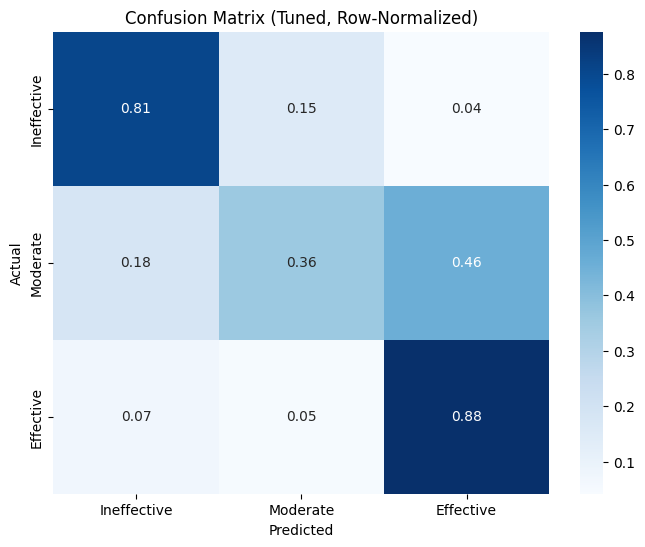

In [17]:
from sklearn.metrics import recall_score

# Upweight Moderate (1), slightly downweight Effective (2)
tuned_class_weights = {0: 2.0, 1: 4.0, 2: 0.4}
tuned_sample_weights = np.array([tuned_class_weights[int(lbl)] for lbl in y_train], dtype=np.float32)

train_data_tuned = lgb.Dataset(X_train, label=y_train, weight=tuned_sample_weights)
val_data_tuned = lgb.Dataset(X_val, label=y_val, reference=train_data_tuned)

# Copy base params so we preserve the original setup
tuned_params = dict(params)

print("Retraining with tuned class weights for Moderate recall...")
tuned_model = lgb.train(
    tuned_params,
    train_data_tuned,
    num_boost_round=1500,
    valid_sets=[train_data_tuned, val_data_tuned],
    callbacks=[
        lgb.early_stopping(stopping_rounds=120),
        lgb.log_evaluation(period=200)
    ]
)

# Apply small probability bias toward Moderate, and slight reduction for Effective
moderate_bias = 1.10
effective_bias = 0.95
probs_adj = tuned_model.predict(X_val)
probs_adj = probs_adj.copy()
probs_adj[:, 1] *= moderate_bias
probs_adj[:, 2] *= effective_bias
probs_adj = probs_adj / probs_adj.sum(axis=1, keepdims=True)

y_pred_tuned = np.argmax(probs_adj, axis=1)
recalls = recall_score(y_val, y_pred_tuned, labels=[0, 1, 2], average=None)
moderate_recall = recalls[1]

print(f"Moderate recall (tuned): {moderate_recall:.3f}")
print("\nClassification Report (tuned):")
print(classification_report(y_val, y_pred_tuned, target_names=['Ineffective', 'Moderate', 'Effective']))

# Save tuned model separately
print("Saving tuned model to 'model_distilbert_tuned.txt'...")
tuned_model.save_model('model_distilbert_tuned.txt')

# Confusion matrix plot (row-normalized)
cm_tuned = confusion_matrix(y_val, y_pred_tuned)
row_sums = cm_tuned.sum(axis=1, keepdims=True)
cm_tuned_norm = np.divide(cm_tuned, row_sums, out=np.zeros_like(cm_tuned, dtype=float), where=row_sums != 0)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm_tuned_norm,
    annot=True,
    fmt='.2f',
    cmap='Blues',
    xticklabels=['Ineffective', 'Moderate', 'Effective'],
    yticklabels=['Ineffective', 'Moderate', 'Effective']
)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Tuned, Row-Normalized)')
plt.show()


In [ ]:
# Optional: use the tuned model in the agent
agent_tuned = MedFollowAgent(
    model=tuned_model,
    tokenizer=tokenizer,
    bert_model=bert_model,
    X_train_embed=X_train_embed,
    train_df=train_df_subset,
    le_condition=le_condition,
    device=DEVICE,
    drug_freq_map=drug_freq_map
)
print("Agent reinitialized with tuned model (agent_tuned).")
